## Forecasting Inflation Using VAR: A Horserace Between Traditional and ML Approaches

https://notes.quantecon.org/submission/5cc8e7dd4174bb001a39a8ff

In [24]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import pandas as pd 
import seaborn as sns
sns.set()
import datetime as dt
import warnings
warnings.simplefilter('ignore')

from sklearn import (linear_model, metrics, neural_network, pipeline, preprocessing, model_selection)
import statsmodels.formula.api as sm

from xgboost import XGBRegressor, plot_importance

In [25]:
# Some cleaning
baltic_data = pd.read_csv("baltics_q.csv")

baltic_data = baltic_data.drop(0)
baltic_data["Date"] = pd.to_datetime(baltic_data["Date"])
# baltic_data = baltic_data.rename(columns={"Date": "date"})
baltic_data = baltic_data.set_index("Date")

baltic_data = baltic_data.dropna()

# # Stationarity in yearly percentage change
# for c in list(baltic_data.columns.values):
#     baltic_data[c + "_diff"] = (baltic_data[c] - baltic_data[c].shift(12))/baltic_data[c].shift(12) * 100

baltic_data.head()

,EE_GDP,LV_GDP,LT_GDP,EE_HICP,LV_HICP,LT_HICP,EE_Un,LV_Un,LT_Un
Date,,,,,,,,,
2000-01-01,2554.1,3092.5,4491.2,3.033333,3.233333,0.933333,15.600000,15.000000,15.766667
2000-04-01,2618.1,3084.2,4537.0,2.966667,3.033333,0.900000,13.900000,14.233333,15.933333
2000-07-01,2650.4,3179.9,4605.3,4.366667,2.500000,0.966667,13.966667,13.833333,17.100000
2000-10-01,2710.0,3141.2,4675.7,5.366667,1.766667,1.566667,14.666667,14.300000,16.966667
2001-01-01,2749.1,3212.9,4788.4,5.766667,1.133333,0.233333,14.200000,14.566667,18.900000


In [26]:
def scatter_plot(data, col_1, col_2, color):
    
    """
    Creates scatter plots for inflation, unemployment rate, GDP
    """
    
    fig, ax = plt.subplots(figsize=(10,4))
    
    ax.scatter(x=data[col_1], y=data[col_2], alpha=0.4, color=color)
    ax.set_xlabel("Inflation", fontname="Verdana")
    
    if col_2 == "EE_Un":
        ax.set_title("Inflation and unemployment rate", fontsize=16, fontname="Verdana", loc="left")
        ax.set_ylabel("Unemployment rate", fontname="Verdana")
    else:
        ax.set_title("Inflation and GDP", fontsize=16, fontname="Verdana", loc="left")
        ax.set_ylabel("GDP", fontname="Verdana")

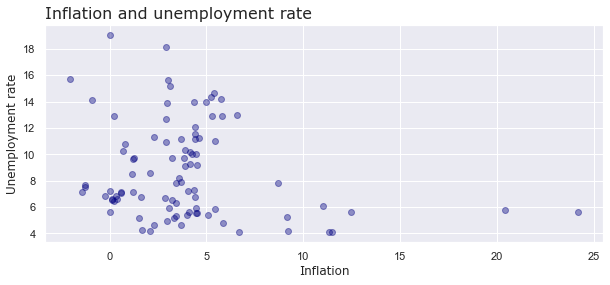

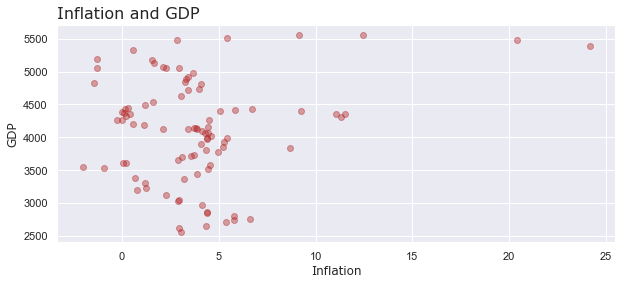

In [27]:
for f,c in dict(zip(["EE_Un", "EE_GDP"], ["navy", "firebrick", "orange"])).items():
    scatter_plot(data=baltic_data, col_1="EE_HICP", col_2=f, color=c)

In [28]:
def scatter_subs(data, col_1, col_2, color):
    
    """
    Break down scatterplots into different years
    """
    
    data1 = data.loc["2000-01-01":"2009-12-01", :]
    data2 = data.loc["2010-01-01":"2019-12-01", :]
    data3 = data.loc["2020-01-01":"2022-12-01", :]

    fig, ax = plt.subplots(1, 3, figsize=(12,4), sharey=True)
    
    ax[0].scatter(x=data1[col_1], y=data1[col_2], alpha=0.4, color=color)
    ax[1].scatter(x=data2[col_1], y=data2[col_2], alpha=0.4, color=color)
    ax[2].scatter(x=data3[col_1], y=data3[col_2], alpha=0.4, color=color)

    ax[0].set_title("2000-2009", fontsize=14, fontname="Verdana")
    ax[1].set_title("2010-2019", fontsize=14, fontname="Verdana")
    ax[2].set_title("2020-2022", fontsize=14, fontname="Verdana")

    for i in list(range(3)):
        ax[i].set_xlabel("Inflation")
        if col_2 == "EE_Un":
            ax[i].set_ylabel("Unemployment rate")
        else:
            ax[i].set_ylabel("GDP")

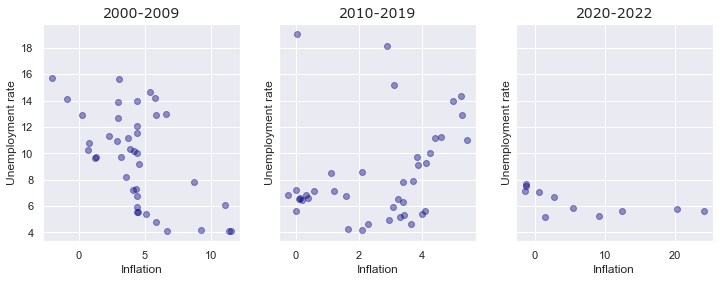

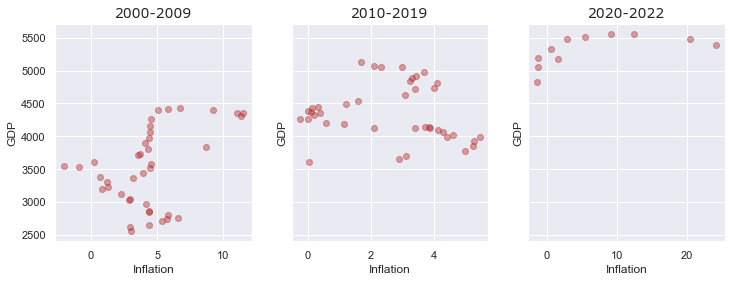

In [29]:
scatter_subs(data=baltic_data, col_1="EE_HICP", col_2="EE_Un", color="navy")
scatter_subs(data=baltic_data, col_1="EE_HICP", col_2="EE_GDP", color="firebrick")

### VAR: Traditional approach

In [30]:
from statsmodels.tsa.api import VAR

# Stationarity
# First differences instead of percentage change
# It seems later on that Lasso had an issue fitting percentage change

for c in list(baltic_data.columns.values):
    baltic_data[c + "_diff"] = baltic_data[c] - baltic_data[c].shift(12)

baltic_data.tail()

,EE_GDP,LV_GDP,LT_GDP,EE_HICP,LV_HICP,LT_HICP,EE_Un,LV_Un,LT_Un,EE_GDP_diff,LV_GDP_diff,LT_GDP_diff,EE_HICP_diff,LV_HICP_diff,LT_HICP_diff,EE_Un_diff,LV_Un_diff,LT_Un_diff
Date,,,,,,,,,,,,,,,,,,
2021-07-01,5512.5,6216.9,10460.7,5.433333,3.700000,5.233333,5.833333,7.200000,6.700000,591.2,283.0,1027.9,2.000000,0.766667,3.066667,0.533333,0.233333,1.100000
2021-10-01,5558.3,6190.1,10577.3,9.133333,7.100000,9.400000,5.233333,7.166667,6.900000,582.5,202.9,1024.9,5.466667,4.233333,7.066667,0.600000,0.333333,0.900000
2022-01-01,5559.0,6300.4,10635.7,12.466667,9.266667,13.966667,5.633333,7.266667,6.366667,507.2,290.8,942.7,10.166667,6.466667,11.900000,1.033333,0.366667,-0.166667
2022-04-01,5484.3,6301.0,10671.8,20.400000,16.366667,18.533333,5.733333,6.633333,5.266667,424.1,259.6,871.1,17.433333,13.066667,16.000000,0.800000,0.266667,-0.866667
2022-07-01,5386.6,6194.6,10726.3,24.166667,21.566667,21.500000,5.600000,6.900000,5.733333,311.5,148.5,882.1,22.066667,18.766667,19.166667,1.433333,0.866667,-0.333333


In [35]:
def plot_vars(data, levels, color, leveltype):
    
    """
    Displays historical trends of VAR variables
    And see if it's sensible to just select levels instead of differences
    """
    
    fig, ax = plt.subplots(1, 3, figsize=(9,2.5), sharex=True)
    
    palettes = ["blue", "green", "red", "orange", "purple", "black"]
    
    for col, i in dict(zip(levels, list(range(6)))).items():
        data[col].plot(ax=ax[i], legend=True, linewidth=1.0, color=color, sharex=True)     
    
    fig.set_facecolor("floralwhite")
    fig.suptitle(f"Historical trends of VAR {leveltype} variables", 
                 fontsize=14, fontweight="bold", fontname="Verdana")

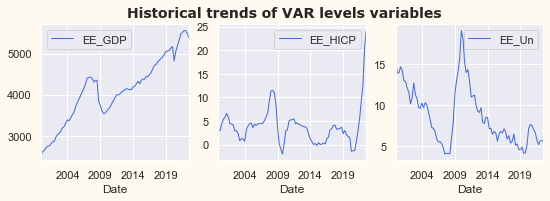

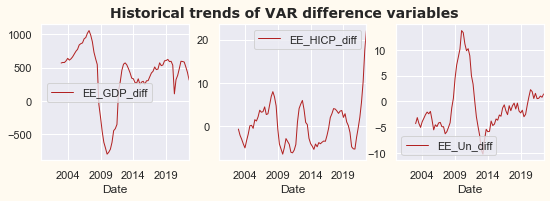

In [36]:
new_names = ['EE_GDP', 'EE_HICP', 'EE_Un']
new_names_diff = ['EE_GDP_diff', 'EE_HICP_diff', 'EE_Un_diff']

plot_vars(baltic_data, levels=new_names, color="royalblue", leveltype="levels")
plot_vars(baltic_data, levels=new_names_diff, color="firebrick", leveltype="difference")

In [44]:
start_date = "2020-07-01"
end_date = "2022-07-01"

def var_create(columns, data):
    
    """
    Creates vector autoregressive model given data and list of selected variables
    Returns the MSE between forecasted and actual values
    Also returns the concatenated dataset for visualization purposes
    """
    
    data = data[columns]
    data = data.dropna(axis=0)
    data.index.to_period("M")
    
    # Split dataset and run VAR on the trained part
    data_train = data.loc["2000-01":"2020-04", :]
    var_train = VAR(data_train)
    results = var_train.fit(12)
    lag_order = results.k_ar
    forecasted = pd.DataFrame(results.forecast(data_train.values[-lag_order:], 24)) # Forecast 24 months
    
    # Rename forecasted columns
    forecasted_names = list(forecasted.columns.values)
    data_train_names = list(data_train.columns.values)
    
    var_dict = dict(zip(forecasted_names, data_train_names))
    
    for f,t in var_dict.items():
        forecasted = forecasted.rename(columns={f:t + "_fcast"})
        
    # forecasted.index = pd.DatetimeIndex(start=start_date, periods=forecasted.shape[0], freq="MS")
    forecasted.index = pd.date_range(start=start_date, periods=forecasted.shape[0], freq="MS")
    forecasted.index.names = ["date"]
    
    # Parse together forecasted data with original dataset
    final_data = pd.merge(forecasted, data, left_index=True, right_index=True)
    final_data = final_data.sort_index(axis=0, ascending=True)
    final_data = pd.concat([data_train, final_data], sort=True, axis=0)
    final_data = final_data.sort_index(axis=0, ascending=True)
    
    var_mse = metrics.mean_squared_error(final_data.loc[start_date:end_date,"EE_HICP_diff_fcast"], 
                           final_data.loc[start_date:end_date,"EE_HICP_diff"])
    
    return var_mse, final_data

In [71]:
mse1, df1 = var_create(columns=["EE_Un_diff", "EE_HICP_diff", "EE_GDP"], data=baltic_data)

print(f"The mean squared error between the forecasted and actual values is {mse1}")

The mean squared error between the forecasted and actual values is 51.80280171948855


In [72]:
def plot_cpi(final_data, var_mse, approach):
    
    """
    Plots the actual values against forecast
    """
    
    fig, ax = plt.subplots(figsize=(14,6))
    colors = sns.color_palette("deep", 8)

    final_data["EE_HICP_diff_fcast"].plot(ax=ax, legend=True, linewidth=2.5, linestyle="dashed")
    final_data["EE_HICP_diff"].plot(ax=ax, legend=True, alpha=0.6, linestyle="solid")
    
    if approach=="traditional":
        ax.set_title("VAR in-sample forecast, traditional approach", fontsize=16, 
                     fontweight="bold", fontname="Verdana", loc="left")
    elif approach=="lasso":
        ax.set_title("VAR in-sample forecast, Lasso approach", fontsize=16, 
                     fontweight="bold", fontname="Verdana", loc="left")
    elif approach=="XGBoost":
        ax.set_title("VAR in-sample forecast, XGBoost approach", fontsize=16, 
                     fontweight="bold", fontname="Verdana", loc="left")
    else:
        ax.set_title("VAR in-sample forecast", fontsize=16, 
                     fontweight="bold", fontname="Verdana", loc="left")
    
    ax.set_ylabel("First differences", fontname="Verdana")
    ax.legend([f"VAR Forecast, MSE={var_mse}", "EE_HICP Real Values"])

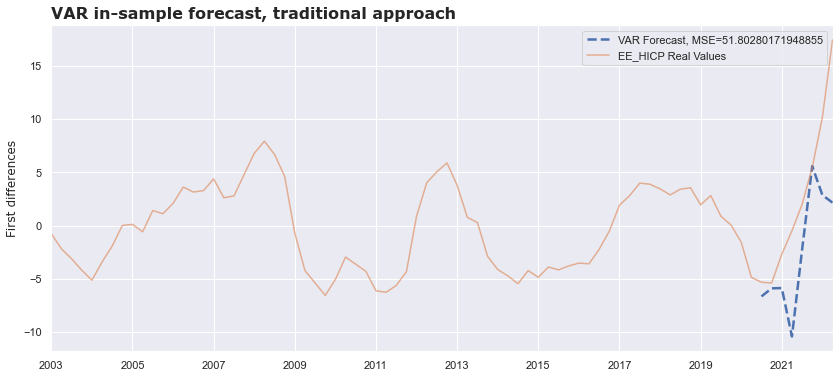

In [73]:
plot_cpi(final_data=df1, var_mse=mse1, approach="traditional")

## VAR: Lasso approach

In [74]:
def timeseries_train_test_split(X, y, testsize):
    """
    This function splits the sample into a trained and test data
    """
    
    X_train = X.loc[:"2020-04-01"] # Until a particular date
    y_train = y.loc[:"2020-04-01"]
    X_test = X.loc["2020-04-01":]
    y_test = y.loc["2020-04-01":]
    
    return X_train, y_train, X_test, y_test

def train_test_plot(model, X_train, X_test):
    """
    This will plot the actual values of CPI against the one fitted by the model
    We train the model until 2020 and then use it from 2020 onwards on the test features dataset
    """
    fig, ax = plt.subplots(figsize=(12,4))
    colors = sns.color_palette("deep", 8)
    
    yvalues = pd.DataFrame(y_test)
    
    forecasted = list(model.predict(X_test)) # Use the model fit on features data from 2009 onwards
    df_fcast = pd.DataFrame({"date": list(yvalues.index), "EE_HICP_fcast": forecasted})
    df_fcast = df_fcast.set_index("date")
    
    df = pd.merge(yvalues, df_fcast, left_index=True, right_index=True)

    df["EE_HICP_fcast"].plot(ax=ax, legend=True, linewidth=2.5, linestyle="dashed", color="forestgreen") # EE_HICP fitted
    df["EE_HICP_diff"].plot(ax=ax, legend=True, linewidth=1.5, linestyle="solid", color="salmon") # Actual EE_HICP values
    
    ax.set_title("EE_HICP vs. Model's EE_HICP")
    ax.set_ylabel("First differences")
    ax.legend(["Fitted EE_HICP","Actual EE_HICP"])

In [76]:
# Split into X and y
cpi_target = baltic_data.dropna().EE_HICP_diff
fred_features = baltic_data.dropna().filter(regex='^EE',axis=1).drop(["EE_HICP_diff"], axis=1)

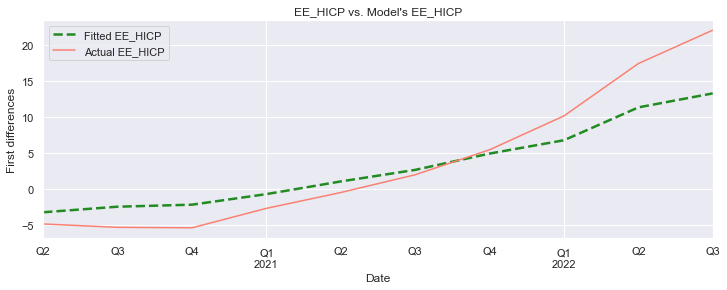

In [77]:
X_train, y_train, X_test, y_test = timeseries_train_test_split(X=fred_features, y=cpi_target, testsize=0.25)

lasso = linear_model.LassoCV(cv=model_selection.TimeSeriesSplit(n_splits=5), 
                             alphas=None, tol = 10000, normalize=True) 

fred_lasso = lasso.fit(X_train, y_train)
optimal_alpha = fred_lasso.alpha_

lasso2 = linear_model.Lasso(alpha=optimal_alpha, normalize=True)
lasso2.fit(X_train, y_train)

train_test_plot(lasso2, X_train, X_test)

In [78]:
metrics.mean_squared_error(y_test, lasso2.predict(X_test))

15.362601842804617

In [79]:
lasso_coefs = pd.DataFrame({"features":list(X_train), "coef": lasso2.coef_})
lasso_coefs = lasso_coefs[lasso_coefs.coef != 0.0]
lasso_coefs.sort_values("coef", ascending=False)

,features,coef
1,EE_HICP,0.607249
3,EE_GDP_diff,0.002338
0,EE_GDP,0.000837


In [83]:
# new_names2 = ['EE_HICP', 'EE_GDP_diff', 'EE_GDP']
new_names2 = lasso_coefs.sort_values("coef", ascending=False)['features'].to_list()

new_names2 = new_names2 + ["EE_HICP_diff"]
mse2, df2 = var_create(columns=new_names2, data=baltic_data)
print(f"The mean squared error between the forecasted and actual values is {mse2}")

The mean squared error between the forecasted and actual values is 47.32287325067975


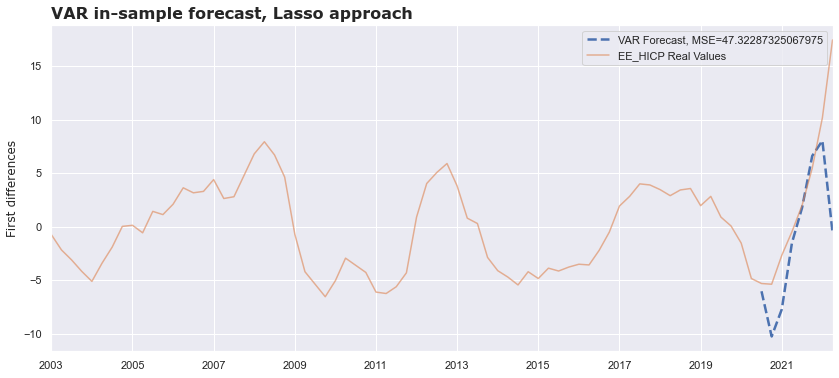

In [84]:
plot_cpi(final_data=df2, var_mse=mse2, approach="lasso")

## VAR: XGBoost approach

In [93]:
fred_features = fred_features[list(fred_features.filter(regex = "_diff"))] # Drop non-stationary variables 
X_train, y_train, X_test, y_test = timeseries_train_test_split(X=fred_features, y=cpi_target, testsize=0.25) 

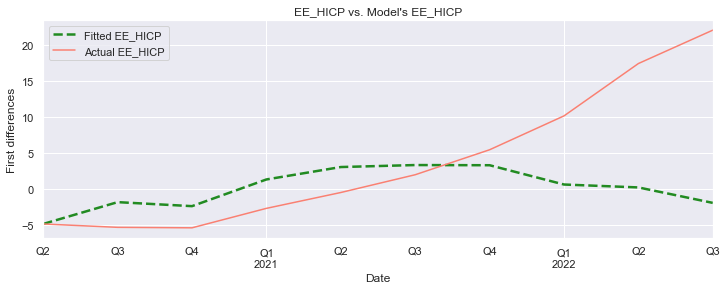

In [94]:
# Build XGBoost
# Normalize the features 
scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

xgb = XGBRegressor()
xgb.fit(X_train_scaled, y_train)

X_test_scaled = scaler.transform(X_test)

train_test_plot(model=xgb, X_train=X_train_scaled, X_test=X_test_scaled)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

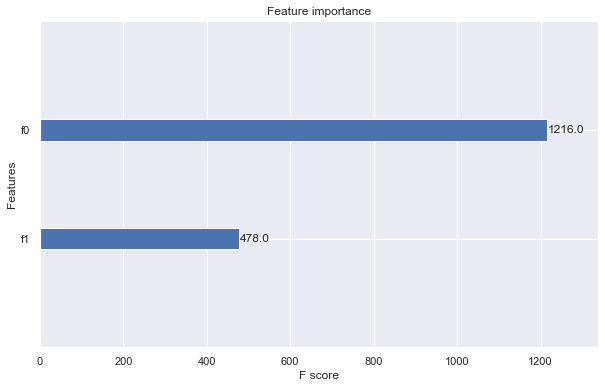

In [95]:
fig_xgb, ax_xgb = plt.subplots(figsize=(10,6))
plot_importance(xgb, max_num_features=5, ax=ax_xgb)

In [96]:
# Feature selection

for i, name in dict(zip(list(range(len(X_train.columns))), list(X_train.columns.values))).items():
    if i == 0:
        print(f"Feature {i} is {name}")
    elif i == 99:
        print(f"Feature {i} is {name}")
    elif i == 106:
        print(f"Feature {i} is {name}")
    elif i == 109:
        print(f"Feature {i} is {name}")
    elif i == 111:
        print(f"Feature {i} is {name}")

Feature 0 is EE_GDP_diff


In [97]:
new_names3 = ["EE_GDP_diff"]

new_names3 = new_names3 + ["EE_HICP_diff"]
mse3, df3 = var_create(columns=new_names3, data=baltic_data)
print(f"The mean squared error between the forecasted and actual values is {mse3}")

The mean squared error between the forecasted and actual values is 46.116652132466946


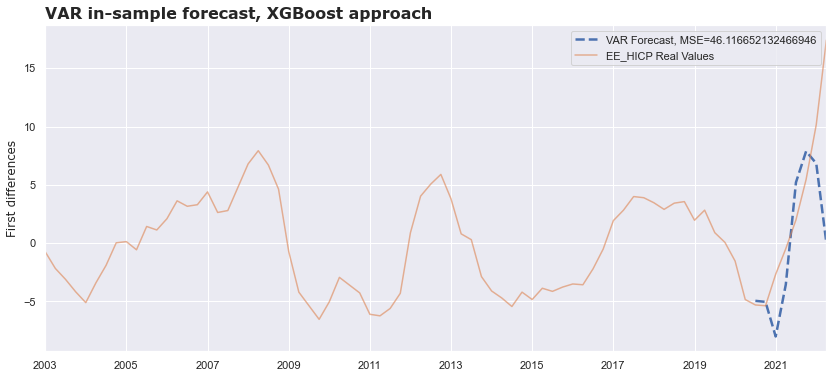

In [98]:
plot_cpi(final_data=df3, var_mse=mse3, approach="XGBoost")

## Conclusions

Text(0, 0.5, 'MSE')

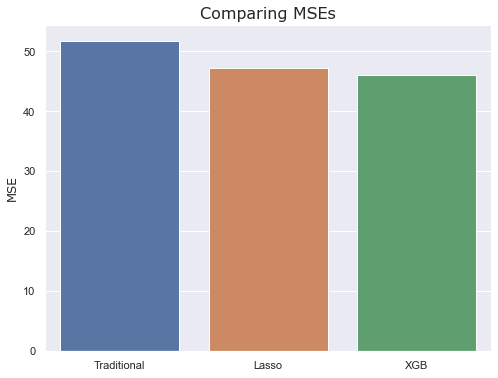

In [99]:
fig, ax = plt.subplots(figsize=(8,6))

ax = sns.barplot(x = ["Traditional", "Lasso", "XGB"], y = [mse1, mse2, mse3])
ax.set_title("Comparing MSEs", fontsize=16, fontname="Verdana")
ax.set_ylabel("MSE", fontname="Verdana")